<center><h1>Mini Project 3</h1></center>
<center><h2>Watchanan Chantapakul (<a href="mailto:wcgzm@umsystem.edu"><code>wcgzm</code></a>)</h2></center>
<hr />

## Questions

Write a program to evaluate the Bayesian belief network for fish in Example 3 of the textbook, using the same information on $P(a_j), P(b_j), P(x_l|a_i), P(x_l|b_j), P(c_k|x_l), and P(d_m|x_l)$.

Test your program on the cases given in that same Example in the textbook. Then, apply your program to the following cases – **present the results in your report**, and state any assumptions you make. You should also try/report other 'queries' (see examples in the figures below).
- (a) A light, thin fish is caught in the North Atlantic in the Summer. What is the probability it is a sea bass?
- (b) A thin, light fish is caught in the North Atlantic. What is the probability it is winter? spring? summer? autumn?
- (c) A medium, thin fish is caught in the Summer. What is the probability it came from the North Atlantic?

>Hint: to solve this problem, you must remember what is $P(A, B | C)$ in terms of $P(A, B)$ and $P(C)$ – then, you must also remember how to find, say for the same example, $P(A,B)$ from $P(A,B,C)$ and $P(C)$ also from $P(A,B,C)$.

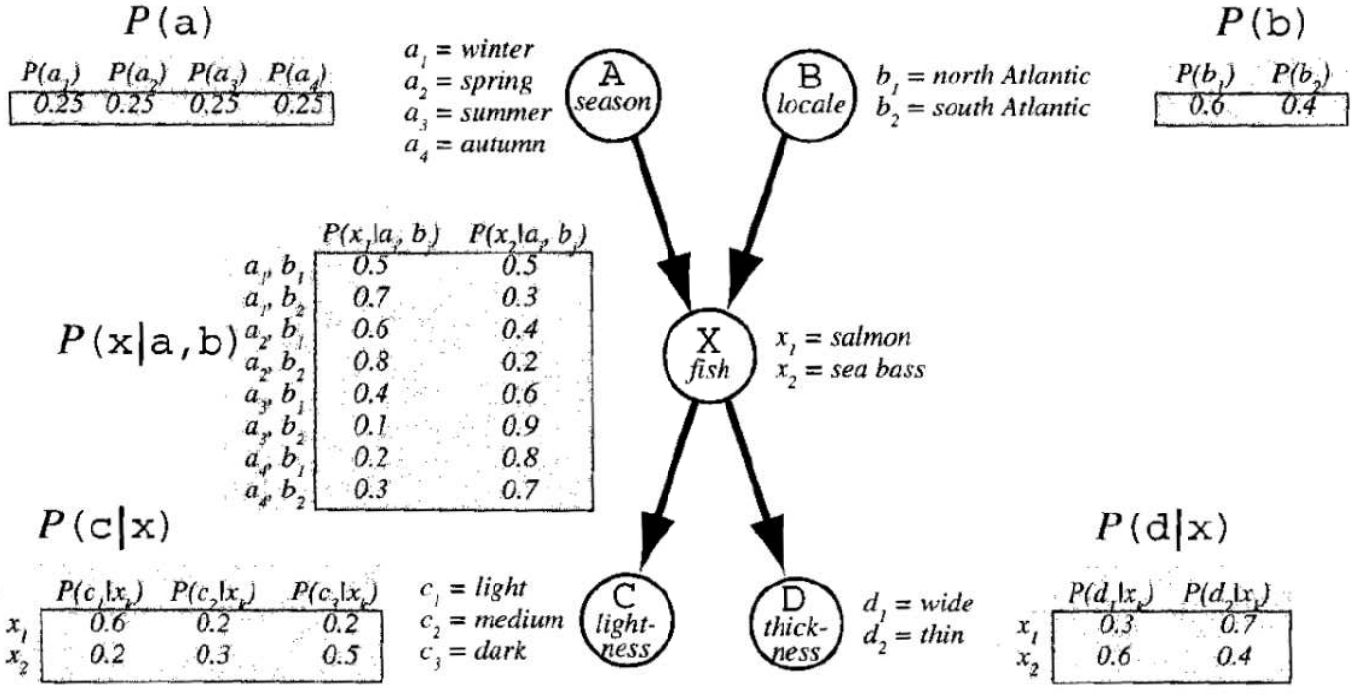

> Figure from Pattern Classification Book by David G. Stork, Peter E. Hart, and Richard O. Duda

In [1]:
import numpy as np
from IPython.display import display, Math

## Belief Network Parameters

According to the figure above, we have to set up our Bayesian belief network:

In [2]:
A = ("winter", "spring", "summer", "autumn")
B = ("north_atlantic", "south_atlantic")
X = ("salmon", "sea_bass")
C = ("light", "medium", "dark")
D = ("wide", "thin")

p_a = [.25, .25, .25, .25]
p_b = [.6, .4]
p_x_ab = [
    [
        [.5, .5],
        [.7, .3]
    ],
    [
        [.6, .4],
        [.8, .2]
    ],
    [
        [.4, .6],
        [.1, .9]
    ],
    [
        [.2, .8],
        [.3, .7]
    ]
]
p_c_x = [
    [.6, .2, .2],
    [.2, .3, .5]
]
p_d_x = [
    [.3, .7],
    [.6, .4]
]

## Bayesian Belief Network

I implemented Bayesian belief network using graph data strcture. So there are two classes here:
1. `Node`
2. `BeliefNet`

In [3]:
class Node():
    def __init__(self, var, names, probs, parents=None):
        self.var = var
        self.names = names
        self.vars = [self.var + str(i+1) for i in range(len(self.names))]
            
        self.probs = probs
        self.parents = parents
        
        self.current = None
        
        self.order = -1

### Conditional Probability

$$ P(x|e) = \frac{P(x,e)}{P(e)} $$
where:
- $x$ is the variables that we want to compute
- $e$ is the evidence (variables excluding $x$)

So, for instance,
$$ P(a,b|c) = \frac{P(a,b,c)}{P(c)} $$
$$ P(x|c,b) = \frac{P(a,b,x,c,d)}{P(c,b)} $$


### Joint Probability

We assume that all random variables are **i.i.d. (independent and identically distributed)**. Simply put, they are statistical indepedent. Thus, we can calculate a joint probability with a product of all probabilities. If a variable is influenced by other variables, it is a conditional probability. Otherwise, it is just a simple probability.

For instance, based on the belief net, we get:
$$ P(a,b,x,c,d) = P(a) \cdot P(b) \cdot P(x|a,b) \cdot P(c|x) \cdot P(d|x) $$

### Marginal Probability

Let $\Theta$ be all variables in a belief net. So, $P(\Theta)$ is the full joint distribution over all the variables. We can compute a probability distribution of a specific variable $x$ by summing the full joint distribution over all variables other than $x$ as follows:
$$ P(x) = \sum_{\Theta - \{x\}}P(\Theta) $$

For example,
$$ P(a,b,x,c) = \sum_{d}P(a,b,x,c,d) $$
$$ P(a,b,x) = \sum_{c,d}P(a,b,x,c,d) $$
$$ P(a,b) = \sum_{x,c,d}P(a,b,x,c,d) $$
$$ P(a) = \sum_{b,x,c,d} P(a,b,x,c,d) $$

$$ P(d) = \sum_{a,b,x,c} P(a,b,x,c,d) $$

In [4]:
class BeliefNet():
    def __init__(self):
        self.nodes = []
        self.order = 0
        self.orders = {}
        
        self.var_names = {}
        self.node_var_nums = {}
    
    def add_node(self, node):
        node.order = self.order
        self.nodes.append(node)
        self.orders[node.var] = node.order
        self.node_var_nums[node.var] = len(node.names)
        self.order += 1
        
        for n, v in zip(node.names, node.vars):
            if n in self.var_names:
                raise KeyError("Duplicate variable names")
            self.var_names[n] = v
            
    """
    PROBABILITY FUNCTIONS
    """
    
    def joint_prob(self, query):
        """ P(a,b,x,c,d) """
        if isinstance(query, list):
            V = self.query_to_vars(query)
        else:
            V, _ = self.extract_query(query)
        cp = 1
        for i, v in enumerate(V):
            cur = self.find_node(v)
            idx = cur.vars.index(V[i])
            if cur.parents is None:
                prob = cur.probs[idx]
            else:
                parent_indices = []
                prob = cur.probs
                for parent in cur.parents:
                    parent_indices.append(parent.current)
                    prob = prob[parent.current]
                prob = prob[idx]
            cur.current = idx
            cp *= prob
        return cp
    
    def marginal_prob(self, query):
        """ P(d) = sum_{a,b,x,c} P(a,b,x,c,d) """
        if isinstance(query, list):
            V = self.query_to_vars(query)
        else:
            V, _ = self.extract_query(query)
        VARS = ["a", "b", "x", "c", "d"]
        
        for v in V:
            VARS.remove(v[0])

        combinations = []
        for v in VARS:
            combinations.append(np.arange(1, self.node_var_nums[v]+1, 1))
        
        prob = 0
        if combinations:
            comb_nums = np.array(
                np.meshgrid(*combinations)
            ).T.reshape(-1, len(combinations))
            for comb in comb_nums:
                in_vars = V.copy()
                for v, c in zip(VARS, comb):
                    in_vars.append(v + str(c))
                in_vars = self.sort_vars(in_vars)
                prob += self.joint_prob(in_vars)
        else:
            prob = self.joint_prob(V)
        return prob

    def cond_prob(self, query):
        """ P(x|e) = P(x,e) / P(e) """
        of, given = self.extract_query(query)
        V = of + given

        numerator = self.marginal_prob(V)
        denominator = self.marginal_prob(given)

        prob = numerator / denominator
        return prob
    
    def prob(self, query):
        if "|" in query: # conditional prob
            return self.cond_prob(query)
        else: # joint prob and marginal prob
            return self.marginal_prob(query)
        
    """
    UTILITY FUNCTIONS
    """
    
    def extract_query(self, query):
        query = query.replace(" ", "")
        split_queries = query.split("|")
        of = split_queries[0]
        given = ""
        if len(split_queries) == 2:
            given = split_queries[1]
        of = of.split(",")
        given = given.split(",")
        if not isinstance(of, list):
            of = [of]
        of = self.query_to_vars(of)
        given = self.query_to_vars(given)
        return of, given
    
    def sort_vars(self, V):
        sorted_V = [''] * len(self.nodes)
        for v in V:
            var_name = v[0]
            sorted_V[self.orders[var_name]] = v
        return sorted_V
        
    def query_to_vars(self, Q):
        V = []
        for q in Q:
            if q in self.var_names:
                for node in self.nodes:
                    try:
                        V.append(node.var + str(node.names.index(q)+1))
                    except ValueError:
                        pass
            else:
                V.append(q)
        return V
    
    def find_node(self, v):
        for node in self.nodes:
            if v in node.vars or v in node.names:
                return node
        return None

Now, create an instance of our Bayesian belief net.

In [5]:
n1 = Node("a", A, p_a)
n2 = Node("b", B, p_b)
n3 = Node("x", X, p_x_ab, [n1, n2])
n4 = Node("c", C, p_c_x, [n3])
n5 = Node("d", D, p_d_x, [n3])

net = BeliefNet()
net.add_node(n1)
net.add_node(n2)
net.add_node(n3)
net.add_node(n4)
net.add_node(n5)

### Examples of how to use a Belief Net instance

In [6]:
print("P(x1,b2,c1)", net.marginal_prob("salmon,south_atlantic,light"))
print("P(x1,b2,c1)", net.marginal_prob("x1,b2,c1"))
print("P(x1,b2,c1)", net.marginal_prob(["x1", "b2", "c1"]))
print("P(c1,b2)", net.marginal_prob(["c1", "b2"]))
print("P(light,south_atlantic)", net.marginal_prob(["light","south_atlantic"]))

Q = ["sea_bass", "thin", "north_atlantic", "summer", "dark"]
V = net.query_to_vars(Q)
print(Q, "->", V)

print("P(['a3', 'b1', 'x2', 'c3', 'd1'])", 
      net.joint_prob(['a3', 'b1', 'x2', 'c3', 'd1']))
print("P(a3,b1,x2,c3,d1)", net.joint_prob("a3,b1,x2,c3,d1"))
print("P(a3,b1,x2,c3,d1)", net.marginal_prob("a3,b1,x2,c3,d1"))

print("P(salmon|light,south_atlantic)", net.cond_prob("salmon|light,south_atlantic"))
print("P(x1|c1,b2)", net.cond_prob("x1|c1,b2"))
print("P(x2|c1,b2)", net.cond_prob("x2|c1,b2"))

P(x1,b2,c1) 0.11399999999999999
P(x1,b2,c1) 0.11399999999999999
P(x1,b2,c1) 0.11399999999999999
P(c1,b2) 0.156
P(light,south_atlantic) 0.156
['sea_bass', 'thin', 'north_atlantic', 'summer', 'dark'] -> ['x2', 'd2', 'b1', 'a3', 'c3']
P(['a3', 'b1', 'x2', 'c3', 'd1']) 0.027
P(a3,b1,x2,c3,d1) 0.027
P(a3,b1,x2,c3,d1) 0.027
P(salmon|light,south_atlantic) 0.7307692307692307
P(x1|c1,b2) 0.7307692307692307
P(x2|c1,b2) 0.2692307692307693


We can achieve the same results as above by using a wrapper function named `prob` which acts as a gateway for other functions. It redirects its input to the corresponding function. If our query is for conditional probability, it will be forwarded to the `cond_prob` function. Otherwise, it will be sent to the `marginal_prob` function (It can serve for both joint probability and marginal probability).

In [7]:
print("P(x1,b2,c1)", net.prob("salmon,south_atlantic,light"))
print("P(x1,b2,c1)", net.prob("x1,b2,c1"))
print("P(x1,b2,c1)", net.prob(["x1", "b2", "c1"]))

print("P(['a3', 'b1', 'x2', 'c3', 'd1'])", net.prob(['a3', 'b1', 'x2', 'c3', 'd1']))
print("P(a3,b1,x2,c3,d1)", net.prob("a3,b1,x2,c3,d1"))
print("P(a3,b1,x2,c3,d1)", net.prob("a3,b1,x2,c3,d1"))

print("P(salmon|light,south_atlantic)", net.prob("salmon|light,south_atlantic"))
print("P(x1|c1,b2)", net.prob("x1|c1,b2"))
print("P(x2|c1,b2)", net.prob("x2|c1,b2"))

P(x1,b2,c1) 0.11399999999999999
P(x1,b2,c1) 0.11399999999999999
P(x1,b2,c1) 0.11399999999999999
P(['a3', 'b1', 'x2', 'c3', 'd1']) 0.027
P(a3,b1,x2,c3,d1) 0.027
P(a3,b1,x2,c3,d1) 0.027
P(salmon|light,south_atlantic) 0.7307692307692307
P(x1|c1,b2) 0.7307692307692307
P(x2|c1,b2) 0.2692307692307693


#### Utility function for displaying an answer

It uses `net.prob` under the hood.

In [8]:
def P(expr):
    ans = net.prob(expr)
    text = expr.replace("_", "\_")
    display(Math(f'P({text}) = {ans:.3f}'))

### Cross-check with examples in the Mini-project 3's hint

In [9]:
P("summer,north_atlantic,sea_bass,dark,thin")
P("x1,b2,c1")
P("c1,b2,x2")
P("south_atlantic,light")
P("x1|b2,c1")
P("x2|b2,c1")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<hr />

## (a) What is the probability that a *sea bass* was caught in the *summer*, in the *North Atlantic* and it is *dark* and *thin*?

- Summer is $a_3$
- North Atlantic is $b_1$
- Sea bass is $x_2$
- Dark is $c_3$
- Thin is $d_2$

$$ P(a_3, b_1, x_2, c_3, d_2) $$

In [10]:
P("summer,north_atlantic,sea_bass,dark,thin")
P("a3,b1,x2,c3,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<hr />

## (b) A *thin*, *light* fish is caught in the *North Atlantic*. What is the probability it is *winter*? *spring*? *summer*? *autumn*?

- North Atlantic is $b_1$
- Light is $c_1$
- Thin is $d_2$

$$ P(a_i | b_1, c_1, d_2) $$

In [11]:
P("winter|north_atlantic,light,thin")
P("a1|north_atlantic,light,thin")
P("a1|b1,c1,d2")
P("winter|b1,c1,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
P("spring|north_atlantic,light,thin")
P("a2|north_atlantic,light,thin")
P("a2|b1,c1,d2")
P("spring|b1,c1,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
P("summer|north_atlantic,light,thin")
P("a3|north_atlantic,light,thin")
P("a3|b1,c1,d2")
P("summer|b1,c1,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
P("autumn|north_atlantic,light,thin")
P("a4|north_atlantic,light,thin")
P("a4|b1,c1,d2")
P("autumn|b1,c1,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### [Sanity check] all of these sum to 1:

In [15]:
ans = net.prob("a1|b1,c1,d2") + net.prob("a2|b1,c1,d2") + \
        net.prob("a3|b1,c1,d2") + net.prob("a4|b1,c1,d2")
display(Math("\sum_{i=1}^{4}P(a_i | b_1, c_1, d_2) =" + f"{ans}"))

<IPython.core.display.Math object>

<hr />

## (c) A *medium*, *thin* fish is caught in the *Summer*. What is the probability it came from the *North Atlantic*?

- Summer is $a_3$
- North Atlantic is $b_1$
- Medium is $c_2$
- Thin is $d_2$

$$ P(b_1| a_3, c_2, d_2) $$

In [16]:
P("north_atlantic|medium,thin,summer")
P("b1|a3,c2,d2")

<IPython.core.display.Math object>

<IPython.core.display.Math object>